In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import os

In [3]:
import lanelines
import roadplane
import straightlanespipeline as slp 

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [4]:
SERIALIZE_DIR = 'serialize'
IM_DIR = 'test_images'

In [5]:
cm = np.load(os.path.join(SERIALIZE_DIR, 'camera_matrix.npy'))
dc = np.load(os.path.join(SERIALIZE_DIR, 'dist_coefs.npy'))

In [6]:
straight_images_files = [os.path.join(IM_DIR, name) for name in ('straight_lines1.jpg', 'straight_lines2.jpg')]
straight_images = [lanelines.open_image(f) for f in straight_images_files]
straight_images_undist = [cv2.undistort(im, cm, dc) for im in straight_images]

In [7]:
test_images = [lanelines.open_image(f) for f in glob(os.path.join(IM_DIR, '*.jpg'))]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

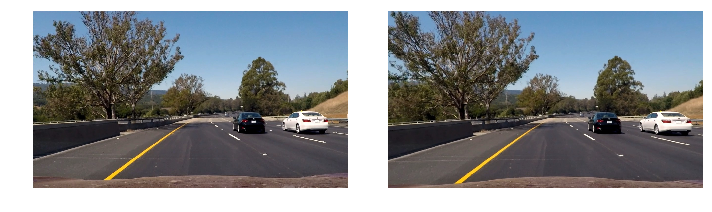

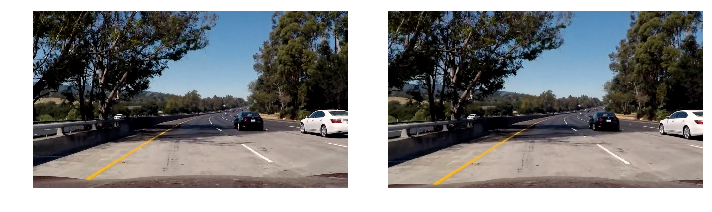

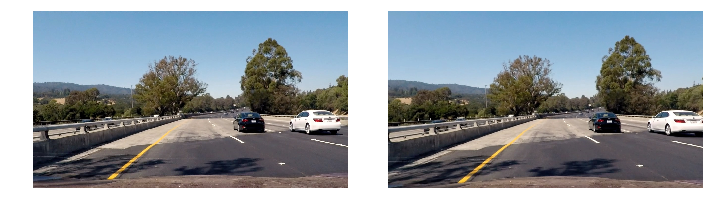

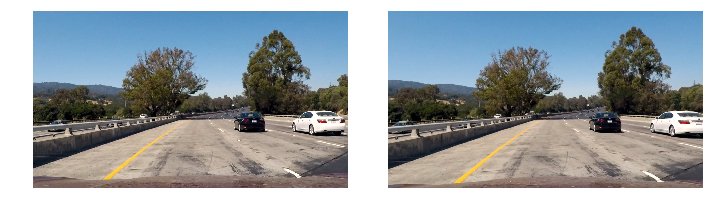

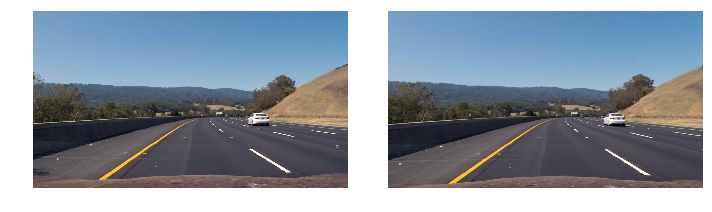

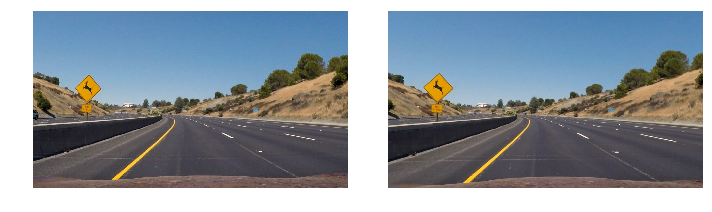

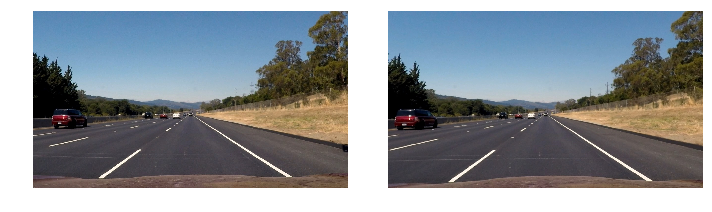

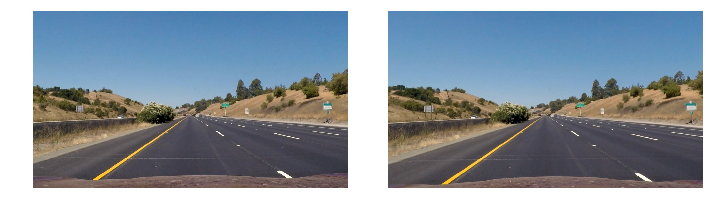

In [8]:
for im, im_undist in zip(test_images, test_images_undist):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    lanelines.imshow_bgr(im)
    plt.subplot(1, 2, 2)
    lanelines.imshow_bgr(im_undist)
    plt.tight_layout()

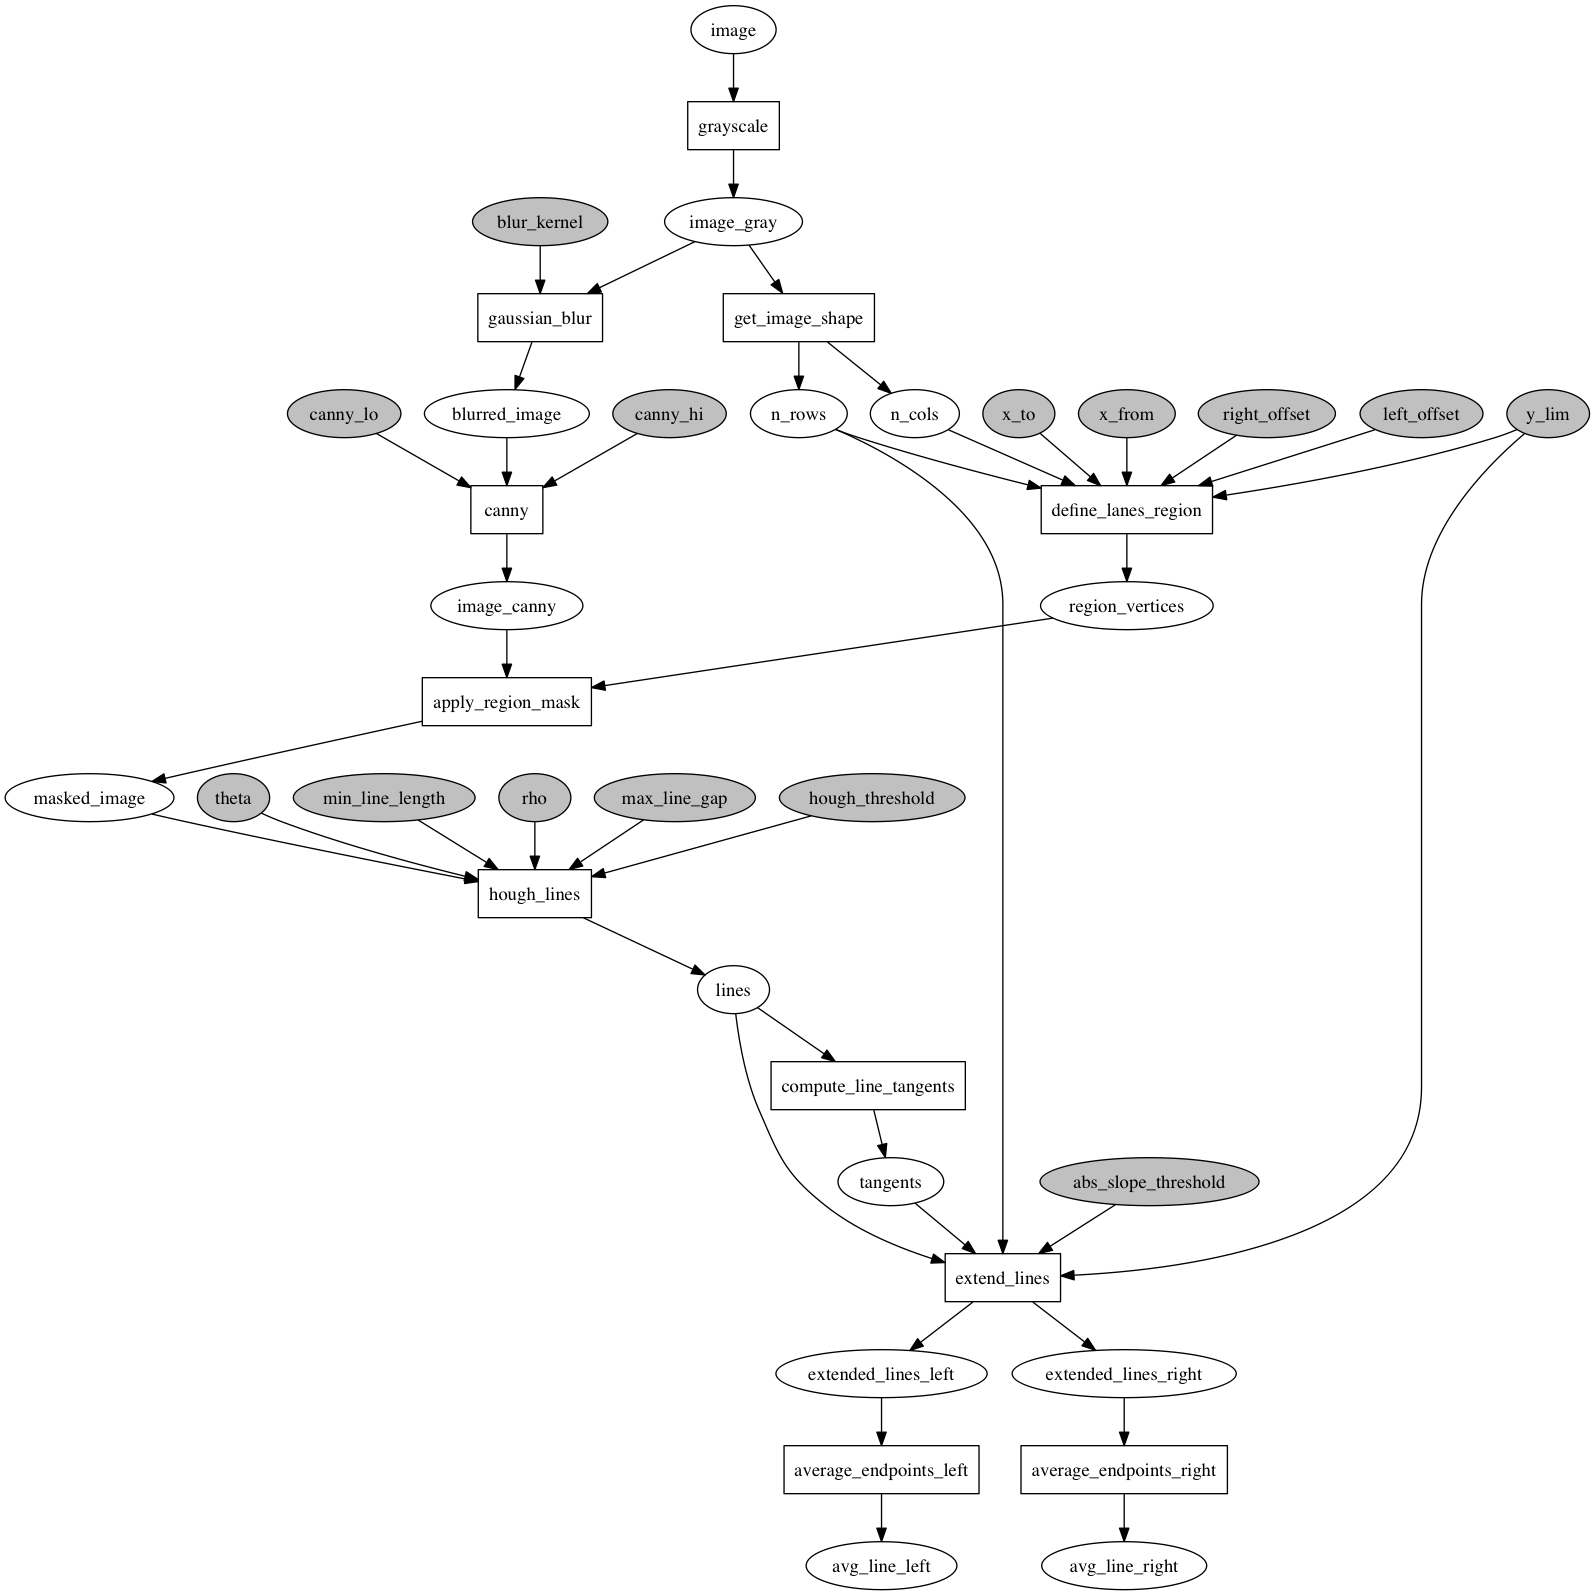

In [9]:
cg = slp.computational_graph
cg_params = slp.parameters

runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

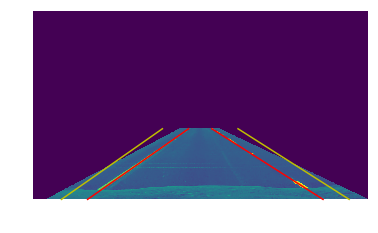

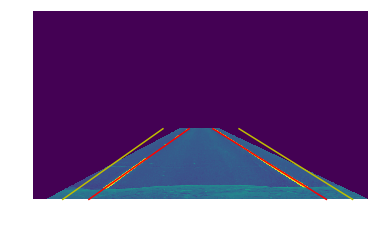

In [10]:
for im in straight_images:
    runner.run(image=im)
    
    plt.figure()
    plt.imshow( lanelines.apply_region_mask(runner['image_gray'], runner['region_vertices']) )
    plt.axis("off")
    
    lanelines.plot_line(runner['avg_line_left'], color='r')
    lanelines.plot_line(runner['avg_line_right'], color='r')
    
    lanelines.plot_line( lanelines.move_line(runner['avg_line_left'], -100), color='y')
    lanelines.plot_line( lanelines.move_line(runner['avg_line_right'], 100), color='y')

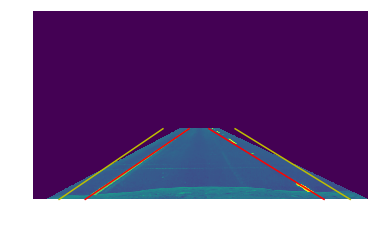

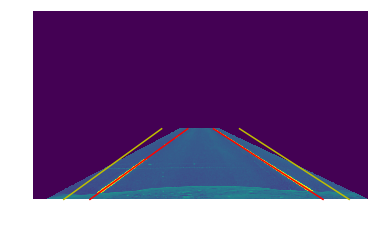

In [11]:
for im in straight_images_undist:
    runner.run(image=im)
    
    plt.figure()
    plt.imshow( lanelines.apply_region_mask(runner['image_gray'], runner['region_vertices']) )
    plt.axis("off")
    
    lanelines.plot_line(runner['avg_line_left'], color='r')
    lanelines.plot_line(runner['avg_line_right'], color='r')
    
    lanelines.plot_line( lanelines.move_line(runner['avg_line_left'], -100), color='y')
    lanelines.plot_line( lanelines.move_line(runner['avg_line_right'], 100), color='y')

In [12]:
def warp_road_image(im, canvas_sz, src, dst):

    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(im, M, canvas_sz, flags=cv2.INTER_LINEAR)

In [13]:
CANVAS_SZ = (500, 1500)
OFFSET_X = 100
OFFSET_Y = 0

warp_src = roadplane.define_flat_plane_on_road(straight_images_undist, x_offset=0)
warp_src[1, 0] += 8 # <- a hack
warp_dst = lanelines.get_rectangle_corners_in_image(CANVAS_SZ, offset_x=OFFSET_X, offset_y=OFFSET_Y)

M = cv2.getPerspectiveTransform(warp_src, warp_dst)

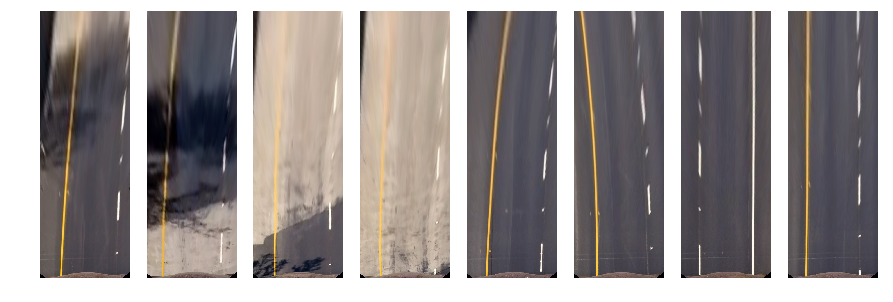

In [14]:
plt.figure(figsize=(15, 5))
for i, im in enumerate(test_images_undist):
    plt.subplot(1, 8, i+1)
    warped = cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR)
    plt.imshow( cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )
    plt.axis('off')

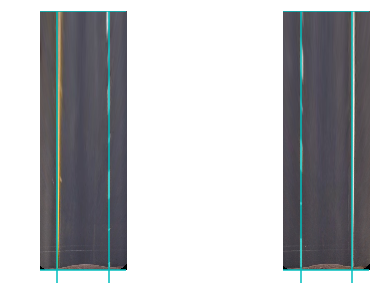

In [15]:
plt.figure(figsize=(8, 5))
for i, im in enumerate(straight_images_undist):
    plt.subplot(1, 2, i+1)
    warped = cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR)
    plt.imshow( cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )
    plt.axis('off')
    
    plt.axvline(OFFSET_X, color='c')
    plt.axvline(CANVAS_SZ[0] - OFFSET_X, color='c')
    
    plt.axhline(OFFSET_Y, color='c')
    plt.axhline(CANVAS_SZ[1] - OFFSET_Y, color='c')

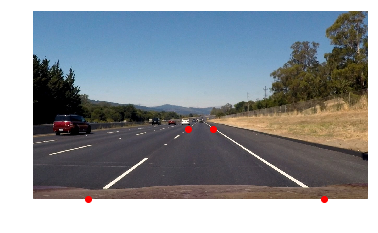

In [16]:
lanelines.imshow_bgr(straight_images[1])
plt.plot(warp_src[:, 0], warp_src[:, 1], 'ro')